# Prepare Data

**Import**

In [9]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.simplefilter(action="ignore", category=FutureWarning)

In [173]:
def wrangle(filepath):
  # Read csv file
  df = pd.read_csv(filepath, encoding='latin1')

  # Replace parenthesis and convert `Year` from obejct to float
  df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype('float64')

  # Remove non-numeric characters (comma, letters etc.)
  df['Votes'] = df['Votes'].replace('[^\d.]', '', regex=True).astype('float64')

  # Split genres and create binary indicator columns
  genres = df['Genre'].str.get_dummies(', ')

  # Concat old and new dataframe
  df = pd.concat([df, genres], axis=1)

  # Fill categorical null values with mode
  categorical_columns = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
  for column in categorical_columns:
    most_frequent_value = df[column].mode()[0]
    df[column].fillna(most_frequent_value, inplace=True)

  # Remove outliers in `Votes`
  low, high = df['Votes'].quantile([0.1, 0.9])
  mask_votes = df['Votes'].between(low, high)

  df = df[mask_votes]

  # Initialize `LabelEncoder` and convert categorical value to numerical value
  encoder = LabelEncoder()
  df['Directors'] = encoder.fit_transform(df['Director'])
  df['Lead Actor'] = encoder.fit_transform(df['Actor 1'])
  df['Supporting Actor'] = encoder.fit_transform(df['Actor 2'])
  df['Side Actor'] = encoder.fit_transform(df['Actor 3'])

   # Columns to be dropped due to above 50% null values, binary indicator columns, high cardinality and categorical value
  drop_columns = ['Duration', 'Genre', 'Name', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

  # Drop columns
  df.drop(columns=drop_columns, inplace=True)

  # Drop old index and reset new index
  df.reset_index(drop=True, inplace=True)

  return df


df = wrangle('dataset/IMDb Movies India.csv')
print(df.shape)
df.info()

(6526, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6526 entries, 0 to 6525
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              6526 non-null   float64
 1   Rating            6526 non-null   float64
 2   Votes             6526 non-null   float64
 3   Action            6526 non-null   int64  
 4   Adventure         6526 non-null   int64  
 5   Animation         6526 non-null   int64  
 6   Biography         6526 non-null   int64  
 7   Comedy            6526 non-null   int64  
 8   Crime             6526 non-null   int64  
 9   Documentary       6526 non-null   int64  
 10  Drama             6526 non-null   int64  
 11  Family            6526 non-null   int64  
 12  Fantasy           6526 non-null   int64  
 13  History           6526 non-null   int64  
 14  Horror            6526 non-null   int64  
 15  Music             6526 non-null   int64  
 16  Musical           6526 non-null

In [209]:
df = pd.read_csv(r'/content/drive/MyDrive/CODSOFT/Movie Rating Prediction/Dataset/IMDb Movies India.csv', encoding='latin1')

In [201]:
df.shape

(15509, 10)

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [14]:
df.head(10)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
5,...Aur Pyaar Ho Gaya,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
7,.in for Motion,(2008),59 min,Documentary,NaN,NaN,Anirban Datta,NaN,NaN,NaN
8,?: A Question Mark,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
9,@Andheri,(2014),116 min,"Action, Crime, Thriller",4.0,11,Biju Bhaskar Nair,Augustine,Fathima Babu,Byon


In [15]:
df.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [16]:
df.isnull().sum() / len(df) * 100

Name         0.000000
Year         3.404475
Duration    53.317429
Genre       12.102650
Rating      48.939326
Votes       48.932878
Director     3.385131
Actor 1     10.426204
Actor 2     15.371720
Actor 3     20.272100
dtype: float64

In [17]:
# Duration column has more than 50% null values
df.drop(columns='Duration', inplace=True)

In [18]:
df['Rating'].value_counts()

6.2     269
6.8     264
6.5     254
6.6     239
6.7     227
       ... 
9.6       1
1.4       1
9.7       1
10.0      1
1.1       1
Name: Rating, Length: 84, dtype: int64

In [19]:
df['Name'].head(10)

0                                      
1    #Gadhvi (He thought he was Gandhi)
2                           #Homecoming
3                               #Yaaram
4                     ...And Once Again
5                  ...Aur Pyaar Ho Gaya
6                             ...Yahaan
7                        .in for Motion
8                    ?: A Question Mark
9                              @Andheri
Name: Name, dtype: object

In [20]:
df['Year'].head()

0       NaN
1    (2019)
2    (2021)
3    (2019)
4    (2010)
Name: Year, dtype: object

In [21]:
df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype('float64')
df['Year'].head()

0       NaN
1    2019.0
2    2021.0
3    2019.0
4    2010.0
Name: Year, dtype: float64

In [22]:
df.nunique()

Name        13838
Year          102
Genre         485
Rating         84
Votes        2034
Director     5938
Actor 1      4718
Actor 2      4891
Actor 3      4820
dtype: int64

In [23]:
df.select_dtypes("object").nunique()

Name        13838
Genre         485
Votes        2034
Director     5938
Actor 1      4718
Actor 2      4891
Actor 3      4820
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  float64
 2   Genre     13632 non-null  object 
 3   Rating    7919 non-null   float64
 4   Votes     7920 non-null   object 
 5   Director  14984 non-null  object 
 6   Actor 1   13892 non-null  object 
 7   Actor 2   13125 non-null  object 
 8   Actor 3   12365 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.1+ MB


In [25]:
df['Votes'].head(10)

0      NaN
1        8
2      NaN
3       35
4      NaN
5      827
6    1,086
7      NaN
8      326
9       11
Name: Votes, dtype: object

In [26]:
df[df['Votes'] == '$5.16M']

,Name,Year,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
9500,Moonlight: Unfortunately a Love Story,2006.0,Comedy,NaN,$5.16M,Raman Bharadwaj,Kim Sharma,Shekhar Suman,Perizaad Zorabian


In [27]:
df[df['Votes'] == 'Vijay Singh'.strip()]

,Name,Year,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3


In [28]:
# Remove non-numeric characters (comma, letters etc.)
df['Votes'] = df['Votes'].replace('[^\d.]', '', regex=True).astype('float64')

In [29]:
df[df['Votes'] == '$5.16M']

,Name,Year,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3


In [30]:
df['Votes'].head(10)

0       NaN
1       8.0
2       NaN
3      35.0
4       NaN
5     827.0
6    1086.0
7       NaN
8     326.0
9      11.0
Name: Votes, dtype: float64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  float64
 2   Genre     13632 non-null  object 
 3   Rating    7919 non-null   float64
 4   Votes     7920 non-null   float64
 5   Director  14984 non-null  object 
 6   Actor 1   13892 non-null  object 
 7   Actor 2   13125 non-null  object 
 8   Actor 3   12365 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.1+ MB


In [32]:
df['Genre'].unique()

array(['Drama', 'Drama, Musical', 'Comedy, Romance',
       'Comedy, Drama, Musical', 'Drama, Romance, War', 'Documentary',
       'Horror, Mystery, Thriller', 'Action, Crime, Thriller', 'Horror',
       'Horror, Romance, Thriller', 'Comedy, Drama, Romance', 'Thriller',
       'Comedy, Drama', nan, 'Comedy, Drama, Fantasy',
       'Comedy, Drama, Family', 'Crime, Drama, Mystery',
       'Horror, Thriller', 'Biography', 'Comedy, Horror', 'Action',
       'Drama, Horror, Mystery', 'Comedy', 'Action, Thriller',
       'Drama, History', 'Drama, History, Sport',
       'Horror, Mystery, Romance', 'Horror, Mystery',
       'Drama, Horror, Romance', 'Action, Drama, History',
       'Action, Drama, War', 'Comedy, Family',
       'Adventure, Horror, Mystery', 'Action, Sci-Fi',
       'Crime, Mystery, Thriller', 'War', 'Sport',
       'Biography, Drama, History', 'Horror, Romance', 'Crime, Drama',
       'Drama, Romance', 'Adventure, Drama', 'Comedy, Mystery, Thriller',
       'Action, Crime, Dr

In [33]:
df['Genre'].nunique()

485

In [34]:
type(df['Genre'])

pandas.core.series.Series

In [35]:
df['Genre'].str.split(', ').head()

0              [Drama]
1              [Drama]
2     [Drama, Musical]
3    [Comedy, Romance]
4              [Drama]
Name: Genre, dtype: object

In [36]:
df['Genre'].str.split(',').explode().head() # We don't want like that

0       Drama
1       Drama
2       Drama
2     Musical
3      Comedy
Name: Genre, dtype: object

In [37]:
x = df['Genre'].str.get_dummies(',').head() # wrong
x

,Action,Adventure,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,...,Horror,Music,Musical,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
x.columns

Index([' Action', ' Adventure', ' Biography', ' Comedy', ' Crime', ' Drama',
       ' Family', ' Fantasy', ' History', ' Horror', ' Music', ' Musical',
       ' Mystery', ' News', ' Reality-TV', ' Romance', ' Sci-Fi', ' Short',
       ' Sport', ' Thriller', ' War', ' Western', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War'],
      dtype='object')

In [39]:
y = df['Genre'].str.get_dummies(', ').head() # correct
y

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
y.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [41]:
# Split genres and create binary indicator columns
genres = df['Genre'].str.get_dummies(', ')
genres.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
df.shape

(15509, 9)

In [43]:
df = pd.concat([df, genres], axis=1)
print(df.shape) 
df.head()

(15509, 33)


,Name,Year,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Action,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia,0,...,0,0,0,0,0,0,0,0,0,0
1,#Gadhvi (He thought he was Gandhi),2019.0,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,0,...,0,0,0,0,0,0,0,0,0,0
2,#Homecoming,2021.0,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana,0,...,0,0,0,0,0,0,0,0,0,0
3,#Yaaram,2019.0,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,0,...,0,0,0,1,0,0,0,0,0,0
4,...And Once Again,2010.0,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df.drop(columns=['Genre'], inplace=True)
print(df.shape) 
df.head()

(15509, 32)


,Name,Year,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Action,Adventure,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,,NaN,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia,0,0,...,0,0,0,0,0,0,0,0,0,0
1,#Gadhvi (He thought he was Gandhi),2019.0,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,0,0,...,0,0,0,0,0,0,0,0,0,0
2,#Homecoming,2021.0,NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana,0,0,...,0,0,0,0,0,0,0,0,0,0
3,#Yaaram,2019.0,4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,0,0,...,0,0,0,1,0,0,0,0,0,0
4,...And Once Again,2010.0,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         15509 non-null  object 
 1   Year         14981 non-null  float64
 2   Rating       7919 non-null   float64
 3   Votes        7920 non-null   float64
 4   Director     14984 non-null  object 
 5   Actor 1      13892 non-null  object 
 6   Actor 2      13125 non-null  object 
 7   Actor 3      12365 non-null  object 
 8   Action       15509 non-null  int64  
 9   Adventure    15509 non-null  int64  
 10  Animation    15509 non-null  int64  
 11  Biography    15509 non-null  int64  
 12  Comedy       15509 non-null  int64  
 13  Crime        15509 non-null  int64  
 14  Documentary  15509 non-null  int64  
 15  Drama        15509 non-null  int64  
 16  Family       15509 non-null  int64  
 17  Fantasy      15509 non-null  int64  
 18  History      15509 non-null  int64  
 19  Horr

In [46]:
df.tail()

,Name,Year,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Action,Adventure,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
15504,Zulm Ko Jala Doonga,1988.0,4.6,11.0,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand,1,0,...,0,0,0,0,0,0,0,0,0,0
15505,Zulmi,1999.0,4.5,655.0,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani,1,0,...,0,0,0,0,0,0,0,0,0,0
15506,Zulmi Raj,2005.0,NaN,NaN,Kiran Thej,Sangeeta Tiwari,NaN,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
15507,Zulmi Shikari,1988.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
15508,Zulm-O-Sitam,1998.0,6.2,20.0,K.C. Bokadia,Dharmendra,Jaya Prada,Arjun Sarja,1,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df['Director'].mode()[0]

'Jayant Desai'

In [48]:
df['Actor 1'].mode()[0]

'Ashok Kumar'

In [49]:
df['Actor 2'].mode()[0]

'Rekha'

In [50]:
df['Actor 3'].mode()[0]

'Pran'

In [51]:
# Fill categorical null values with mode
categorical_columns = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
for column in categorical_columns:
    most_frequent_value = df[column].mode()[0]
    df[column].fillna(most_frequent_value, inplace=True)

In [52]:
df.tail()

,Name,Year,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Action,Adventure,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
15504,Zulm Ko Jala Doonga,1988.0,4.6,11.0,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand,1,0,...,0,0,0,0,0,0,0,0,0,0
15505,Zulmi,1999.0,4.5,655.0,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani,1,0,...,0,0,0,0,0,0,0,0,0,0
15506,Zulmi Raj,2005.0,NaN,NaN,Kiran Thej,Sangeeta Tiwari,Rekha,Pran,1,0,...,0,0,0,0,0,0,0,0,0,0
15507,Zulmi Shikari,1988.0,NaN,NaN,Jayant Desai,Ashok Kumar,Rekha,Pran,1,0,...,0,0,0,0,0,0,0,0,0,0
15508,Zulm-O-Sitam,1998.0,6.2,20.0,K.C. Bokadia,Dharmendra,Jaya Prada,Arjun Sarja,1,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         15509 non-null  object 
 1   Year         14981 non-null  float64
 2   Rating       7919 non-null   float64
 3   Votes        7920 non-null   float64
 4   Director     15509 non-null  object 
 5   Actor 1      15509 non-null  object 
 6   Actor 2      15509 non-null  object 
 7   Actor 3      15509 non-null  object 
 8   Action       15509 non-null  int64  
 9   Adventure    15509 non-null  int64  
 10  Animation    15509 non-null  int64  
 11  Biography    15509 non-null  int64  
 12  Comedy       15509 non-null  int64  
 13  Crime        15509 non-null  int64  
 14  Documentary  15509 non-null  int64  
 15  Drama        15509 non-null  int64  
 16  Family       15509 non-null  int64  
 17  Fantasy      15509 non-null  int64  
 18  History      15509 non-null  int64  
 19  Horr

In [54]:
def wrangle(filepath):
  # Read csv file
  df = pd.read_csv(filepath, encoding='latin1')

  # Replace parenthesis and convert `Year` from obejct to float
  df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype('float64')

  # Remove non-numeric characters (comma, letters etc.)
  df['Votes'] = df['Votes'].replace('[^\d.]', '', regex=True).astype('float64')

  # Split genres and create binary indicator columns
  genres = df['Genre'].str.get_dummies(', ')

  # Concat old and new dataframe
  df = pd.concat([df, genres], axis=1)

  # Columns to be dropped due to above 50% null values and binary indicator columns
  drop_columns = ['Duration', 'Genre']

  # Duration column with more than 50% null values
  df.drop(columns=drop_columns, inplace=True)

  # Fill categorical null values with mode
  categorical_columns = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
  for column in categorical_columns:
    most_frequent_value = df[column].mode()[0]
    df[column].fillna(most_frequent_value, inplace=True)

  return df

In [55]:
df = wrangle('dataset/IMDb Movies India.csv')
print(df.shape)
df.info()

(15509, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         15509 non-null  object 
 1   Year         14981 non-null  float64
 2   Rating       7919 non-null   float64
 3   Votes        7920 non-null   float64
 4   Director     15509 non-null  object 
 5   Actor 1      15509 non-null  object 
 6   Actor 2      15509 non-null  object 
 7   Actor 3      15509 non-null  object 
 8   Action       15509 non-null  int64  
 9   Adventure    15509 non-null  int64  
 10  Animation    15509 non-null  int64  
 11  Biography    15509 non-null  int64  
 12  Comedy       15509 non-null  int64  
 13  Crime        15509 non-null  int64  
 14  Documentary  15509 non-null  int64  
 15  Drama        15509 non-null  int64  
 16  Family       15509 non-null  int64  
 17  Fantasy      15509 non-null  int64  
 18  History      15509 non-null  int64

**Explore**

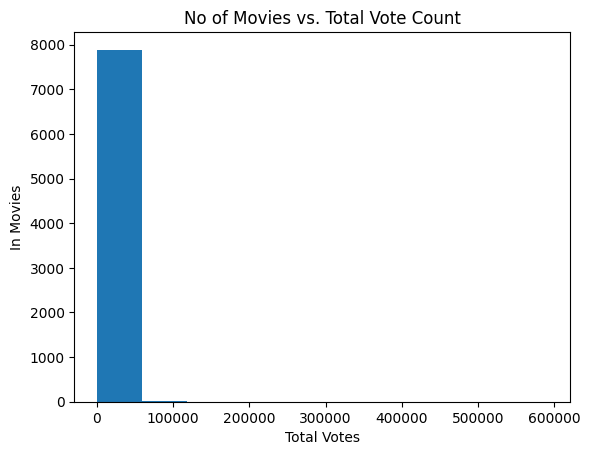

In [56]:
plt.hist(df['Votes'])
plt.xlabel('Total Votes')
plt.ylabel('In Movies')
plt.title('No of Movies vs. Total Vote Count');

In [57]:
df['Votes'].describe()

count      7920.000000
mean       1938.276283
std       11601.703700
min           5.000000
25%          16.000000
50%          55.000000
75%         404.000000
max      591417.000000
Name: Votes, dtype: float64

In [58]:
low, high = df['Votes'].quantile([0.1, 0.9])
low, high

(8.0, 2965.800000000003)

In [59]:
mask_votes = df['Votes'].between(low, high)
mask_votes.head()

0    False
1     True
2    False
3     True
4    False
Name: Votes, dtype: bool

In [60]:
df[mask_votes].head()

,Name,Year,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Action,Adventure,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,#Gadhvi (He thought he was Gandhi),2019.0,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,0,0,...,0,0,0,0,0,0,0,0,0,0
3,#Yaaram,2019.0,4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,0,0,...,0,0,0,1,0,0,0,0,0,0
5,...Aur Pyaar Ho Gaya,1997.0,4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,0,0,...,0,0,0,0,0,0,0,0,0,0
6,...Yahaan,2005.0,7.4,1086.0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,0,0,...,0,0,0,1,0,0,0,0,1,0
8,?: A Question Mark,2012.0,5.6,326.0,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,0,0,...,1,0,0,0,0,0,0,1,0,0


In [61]:
df = df[mask_votes]

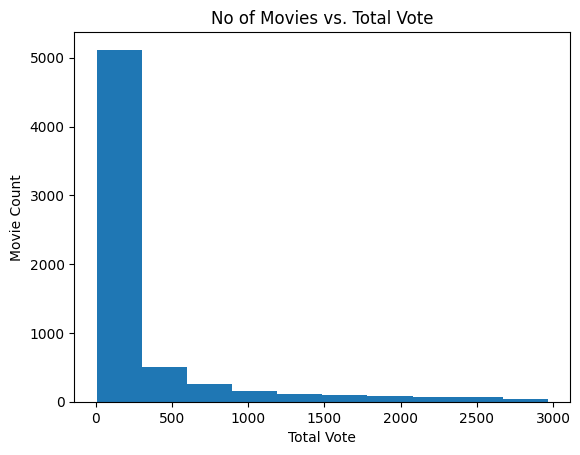

In [62]:
plt.hist(df['Votes'])
plt.xlabel('Total Vote')
plt.ylabel('Movie Count')
plt.title('No of Movies vs. Total Vote');

In [63]:
df['Votes'].describe()

count    6526.000000
mean      278.831443
std       531.920442
min         8.000000
25%        19.000000
50%        51.000000
75%       236.750000
max      2965.000000
Name: Votes, dtype: float64

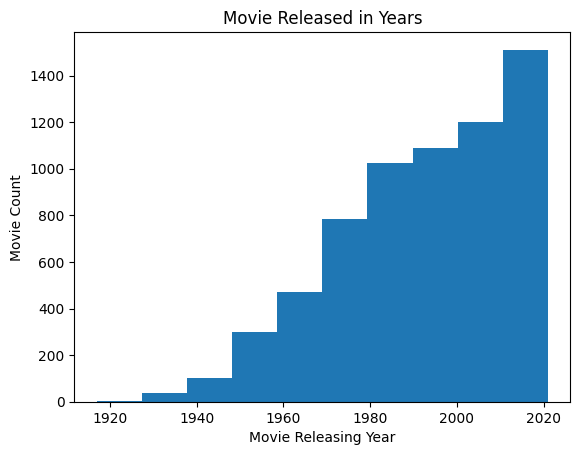

In [64]:
plt.hist(df['Year'])
plt.xlabel('Movie Releasing Year')
plt.ylabel('Movie Count')
plt.title('Movie Released in Years');

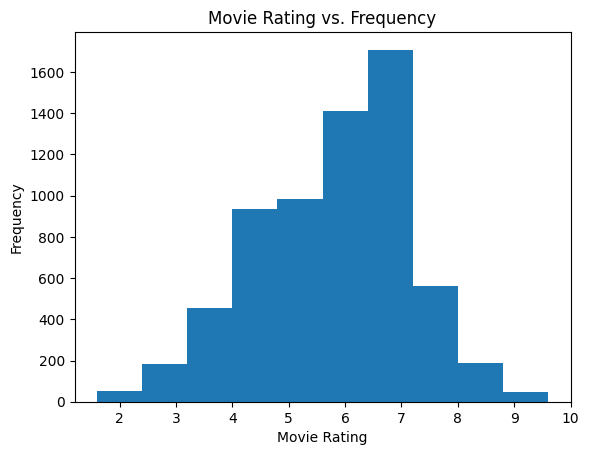

In [65]:
plt.hist(df['Rating'])
plt.xlabel('Movie Rating')
plt.ylabel('Frequency')
plt.title('Movie Rating vs. Frequency');

In [66]:
df['Director'].describe()

count             6526
unique            2743
top       Mahesh Bhatt
freq                42
Name: Director, dtype: object

In [67]:
df['Director'].sort_values().tail()

5871       Zia Sarhadi
14897    Ziaullah Khan
8084       Zubair Khan
5083       Zubair Khan
14066     Zunaid Memon
Name: Director, dtype: object

In [68]:
df['Director'].value_counts().sort_values().tail()

Basu Chatterjee         33
Rama Rao Tatineni       34
Shakti Samanta          37
Hrishikesh Mukherjee    38
Mahesh Bhatt            42
Name: Director, dtype: int64

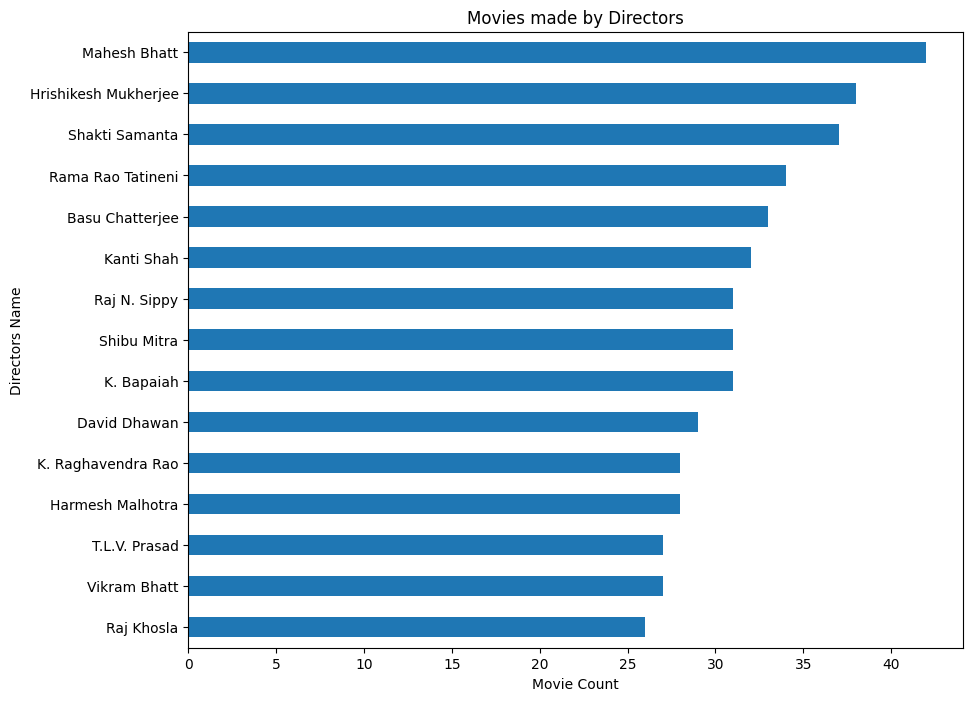

In [69]:
director_counts = df['Director'].value_counts().sort_values().tail(15)

plt.figure(figsize=(10, 8))
director_counts.plot(kind='barh')
plt.xlabel('Movie Count')
plt.ylabel('Directors Name')
plt.title('Movies made by Directors')
plt.show();

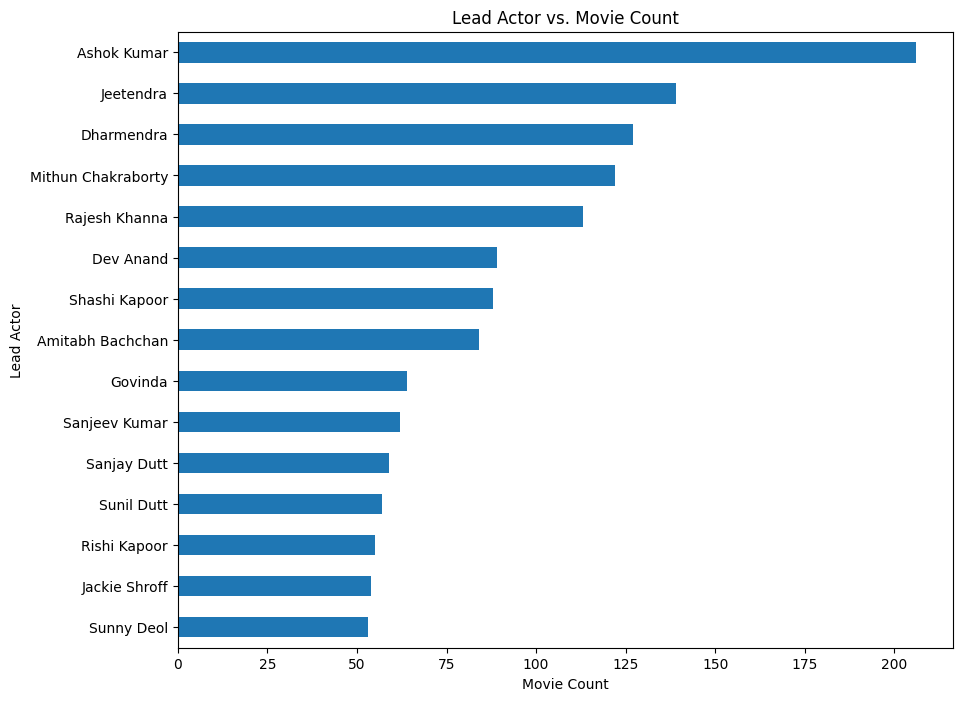

In [70]:
lead_actor_counts = df['Actor 1'].value_counts().sort_values().tail(15)

plt.figure(figsize=(10, 8))
lead_actor_counts.plot(kind='barh')
plt.xlabel('Movie Count')
plt.ylabel('Lead Actor')
plt.title('Lead Actor vs. Movie Count')
plt.show();

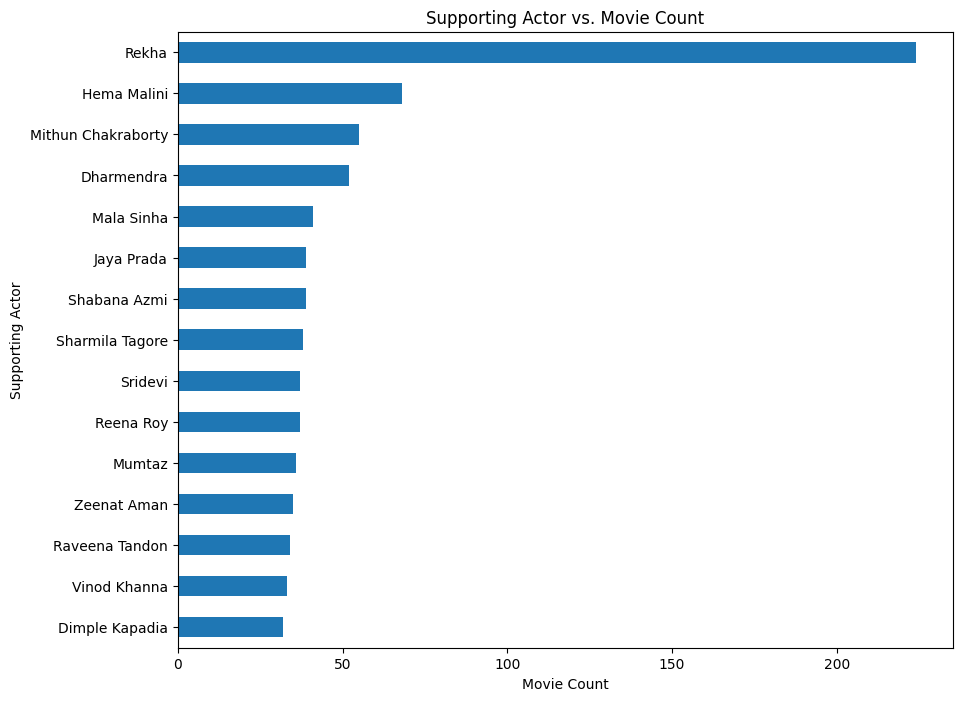

In [71]:
supporting_actor_counts = df['Actor 2'].value_counts().sort_values().tail(15)

plt.figure(figsize=(10, 8))
supporting_actor_counts.plot(kind='barh')
plt.xlabel('Movie Count')
plt.ylabel('Supporting Actor')
plt.title('Supporting Actor vs. Movie Count')
plt.show();

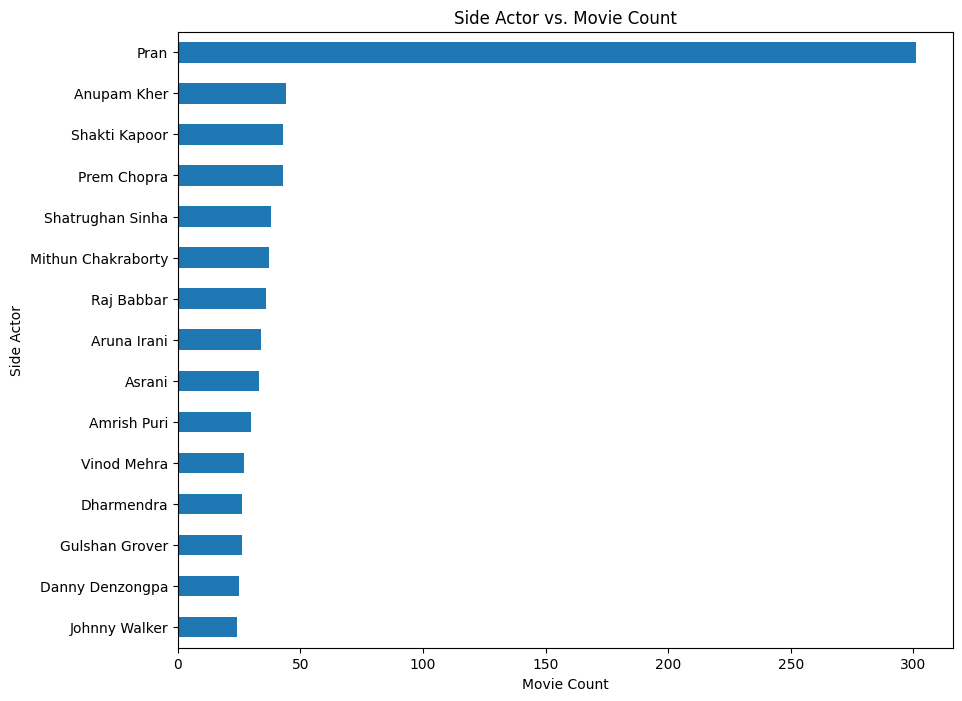

In [72]:
side_actor_counts = df['Actor 3'].value_counts().sort_values().tail(15)

plt.figure(figsize=(10, 8))
side_actor_counts.plot(kind='barh')
plt.xlabel('Movie Count')
plt.ylabel('Side Actor')
plt.title('Side Actor vs. Movie Count')
plt.show();

In [73]:
features = df.columns[1:8]
features

Index(['Year', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], dtype='object')

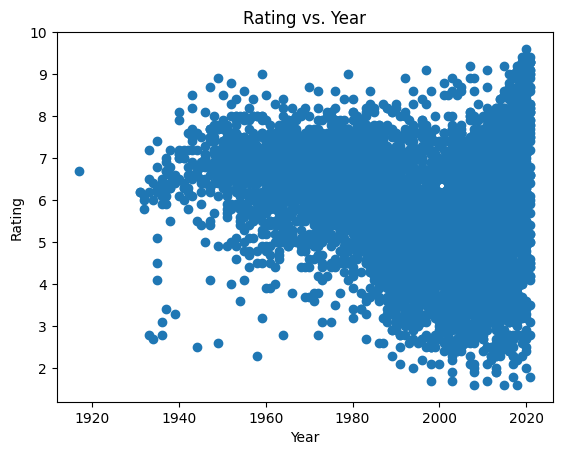

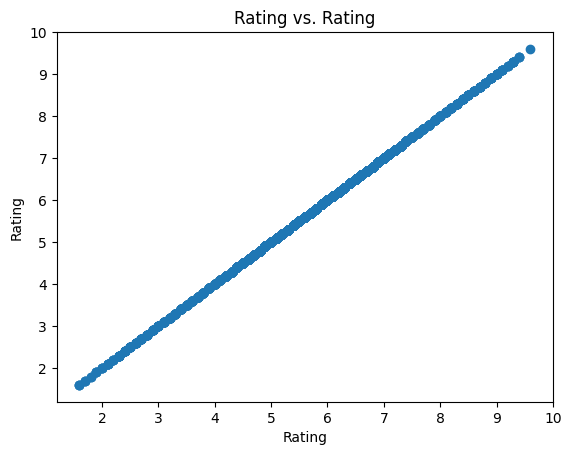

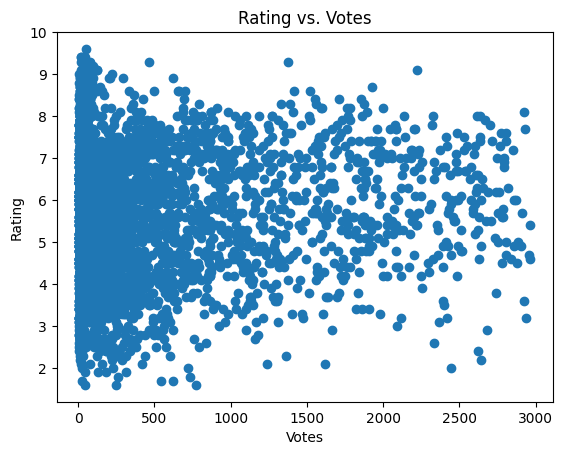

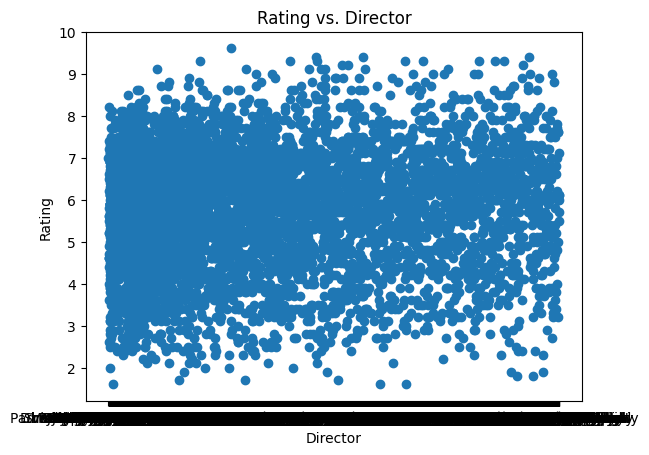

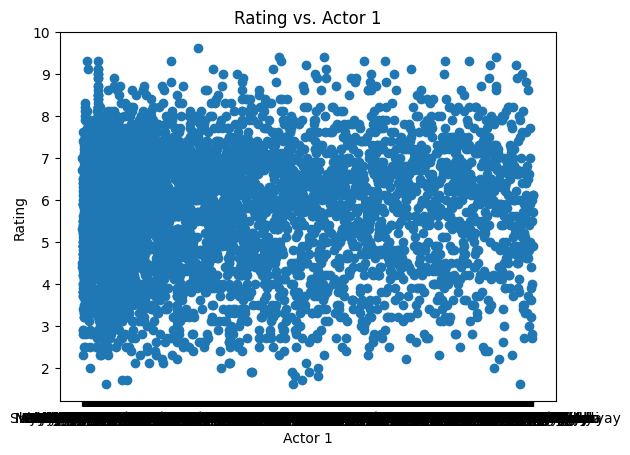

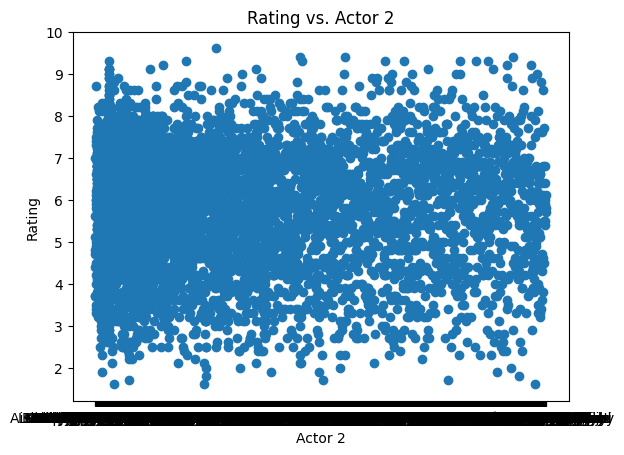

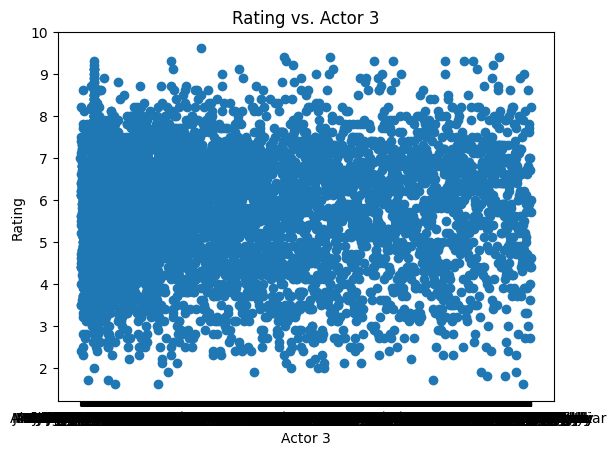

In [74]:
for feature in features:
  plt.scatter(x=df[feature], y=df['Rating'])
  plt.xlabel(feature)
  plt.ylabel('Rating')
  plt.title(f'Rating vs. {feature}')
  plt.show();

In [75]:
def wrangle(filepath):
  # Read csv file
  df = pd.read_csv(filepath, encoding='latin1')

  # Replace parenthesis and convert `Year` from obejct to float
  df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype('float64')

  # Remove non-numeric characters (comma, letters etc.)
  df['Votes'] = df['Votes'].replace('[^\d.]', '', regex=True).astype('float64')

  # Split genres and create binary indicator columns
  genres = df['Genre'].str.get_dummies(', ')

  # Concat old and new dataframe
  df = pd.concat([df, genres], axis=1)

  # Columns to be dropped due to above 50% null values and binary indicator columns
  drop_columns = ['Duration', 'Genre']

  # Drop columns
  df.drop(columns=drop_columns, inplace=True)

  # Fill categorical null values with mode
  categorical_columns = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
  for column in categorical_columns:
    most_frequent_value = df[column].mode()[0]
    df[column].fillna(most_frequent_value, inplace=True)

  # Remove outliers in `Votes`
  low, high = df['Votes'].quantile([0.1, 0.9])
  mask_votes = df['Votes'].between(low, high)

  df = df[mask_votes]

  # Drop old index and reset new index
  df.reset_index(drop=True, inplace=True)

  return df

In [76]:
df = wrangle('dataset/IMDb Movies India.csv')
print(df.shape)
df.info()

(6526, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6526 entries, 0 to 6525
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         6526 non-null   object 
 1   Year         6526 non-null   float64
 2   Rating       6526 non-null   float64
 3   Votes        6526 non-null   float64
 4   Director     6526 non-null   object 
 5   Actor 1      6526 non-null   object 
 6   Actor 2      6526 non-null   object 
 7   Actor 3      6526 non-null   object 
 8   Action       6526 non-null   int64  
 9   Adventure    6526 non-null   int64  
 10  Animation    6526 non-null   int64  
 11  Biography    6526 non-null   int64  
 12  Comedy       6526 non-null   int64  
 13  Crime        6526 non-null   int64  
 14  Documentary  6526 non-null   int64  
 15  Drama        6526 non-null   int64  
 16  Family       6526 non-null   int64  
 17  Fantasy      6526 non-null   int64  
 18  History      6526 non-null   int64  


In [77]:
df.head()

,Name,Year,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Action,Adventure,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,#Gadhvi (He thought he was Gandhi),2019.0,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,0,0,...,0,0,0,0,0,0,0,0,0,0
1,#Yaaram,2019.0,4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,0,0,...,0,0,0,1,0,0,0,0,0,0
2,...Aur Pyaar Ho Gaya,1997.0,4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,0,0,...,0,0,0,0,0,0,0,0,0,0
3,...Yahaan,2005.0,7.4,1086.0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,0,0,...,0,0,0,1,0,0,0,0,1,0
4,?: A Question Mark,2012.0,5.6,326.0,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,0,0,...,1,0,0,0,0,0,0,1,0,0


In [78]:
df['Actor 1'].value_counts()

Ashok Kumar             206
Jeetendra               139
Dharmendra              127
Mithun Chakraborty      122
Rajesh Khanna           113
                       ... 
Mohammad Reza Golzar      1
Shubha Khote              1
Amitoj Mann               1
Naman Jain                1
K. Prasad                 1
Name: Actor 1, Length: 2242, dtype: int64

In [79]:
df['Actor 1'].describe()

count            6526
unique           2242
top       Ashok Kumar
freq              206
Name: Actor 1, dtype: object

In [80]:
from sklearn.preprocessing import LabelEncoder

In [81]:
encoder = LabelEncoder()

In [82]:
df['Lead Actor'] = encoder.fit_transform(df['Actor 1'])
df['Lead Actor'].head()

0    1563
1    1389
2     454
3     812
4    2218
Name: Lead Actor, dtype: int64

In [84]:
df['Supporting Actor'] = encoder.fit_transform(df['Actor 2'])
df['Supporting Actor'].head()

0    2469
1     785
2      75
3    1217
4    1280
Name: Supporting Actor, dtype: int64

In [85]:
df['Side Actor'] = encoder.fit_transform(df['Actor 3'])
df['Side Actor'].head()

0     335
1    2258
2    2149
3    2659
4    1057
Name: Side Actor, dtype: int64

In [89]:
df['Directors'] = encoder.fit_transform(df['Director'])
df['Directors'].head()

0     708
1    1530
2    1753
3    2310
4     143
Name: Directors, dtype: int64

In [90]:
df.head()

,Name,Year,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Action,Adventure,...,Sci-Fi,Short,Sport,Thriller,War,Western,Lead Actor,Supporting Actor,Side Actor,Directors
0,#Gadhvi (He thought he was Gandhi),2019.0,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,0,0,...,0,0,0,0,0,0,1563,2469,335,708
1,#Yaaram,2019.0,4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,0,0,...,0,0,0,0,0,0,1389,785,2258,1530
2,...Aur Pyaar Ho Gaya,1997.0,4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,0,0,...,0,0,0,0,0,0,454,75,2149,1753
3,...Yahaan,2005.0,7.4,1086.0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,0,0,...,0,0,0,0,1,0,812,1217,2659,2310
4,?: A Question Mark,2012.0,5.6,326.0,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,0,0,...,0,0,0,1,0,0,2218,1280,1057,143


In [94]:
df.duplicated().groupby(df.duplicated()).sum()

False    0
dtype: int64

In [95]:
df.drop(columns=['Name', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], inplace=True)

In [96]:
df.head()

,Year,Rating,Votes,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Sci-Fi,Short,Sport,Thriller,War,Western,Lead Actor,Supporting Actor,Side Actor,Directors
0,2019.0,7.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1563,2469,335,708
1,2019.0,4.4,35.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1389,785,2258,1530
2,1997.0,4.7,827.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,454,75,2149,1753
3,2005.0,7.4,1086.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,812,1217,2659,2310
4,2012.0,5.6,326.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,2218,1280,1057,143


In [97]:
def wrangle(filepath):
  # Read csv file
  df = pd.read_csv(filepath, encoding='latin1')

  # Replace parenthesis and convert `Year` from obejct to float
  df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype('float64')

  # Remove non-numeric characters (comma, letters etc.)
  df['Votes'] = df['Votes'].replace('[^\d.]', '', regex=True).astype('float64')

  # Split genres and create binary indicator columns
  genres = df['Genre'].str.get_dummies(', ')

  # Concat old and new dataframe
  df = pd.concat([df, genres], axis=1)

  # Fill categorical null values with mode
  categorical_columns = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
  for column in categorical_columns:
    most_frequent_value = df[column].mode()[0]
    df[column].fillna(most_frequent_value, inplace=True)

  # Remove outliers in `Votes`
  low, high = df['Votes'].quantile([0.1, 0.9])
  mask_votes = df['Votes'].between(low, high)

  df = df[mask_votes]

  # Initialize `LabelEncoder` and convert categorical value to numerical value
  encoder = LabelEncoder()
  df['Directors'] = encoder.fit_transform(df['Director'])
  df['Lead Actor'] = encoder.fit_transform(df['Actor 1'])
  df['Supporting Actor'] = encoder.fit_transform(df['Actor 2'])
  df['Side Actor'] = encoder.fit_transform(df['Actor 3'])

   # Columns to be dropped due to above 50% null values, binary indicator columns, high cardinality and categorical value
  drop_columns = ['Duration', 'Genre', 'Name', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

  # Drop columns
  df.drop(columns=drop_columns, inplace=True)

  # Drop old index and reset new index
  df.reset_index(drop=True, inplace=True)

  return df

In [98]:
df = wrangle('dataset/IMDb Movies India.csv')
print(df.shape)
df.info()

(6526, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6526 entries, 0 to 6525
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              6526 non-null   float64
 1   Rating            6526 non-null   float64
 2   Votes             6526 non-null   float64
 3   Action            6526 non-null   int64  
 4   Adventure         6526 non-null   int64  
 5   Animation         6526 non-null   int64  
 6   Biography         6526 non-null   int64  
 7   Comedy            6526 non-null   int64  
 8   Crime             6526 non-null   int64  
 9   Documentary       6526 non-null   int64  
 10  Drama             6526 non-null   int64  
 11  Family            6526 non-null   int64  
 12  Fantasy           6526 non-null   int64  
 13  History           6526 non-null   int64  
 14  Horror            6526 non-null   int64  
 15  Music             6526 non-null   int64  
 16  Musical           6526 non-null

In [99]:
df.head()

,Year,Rating,Votes,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Sci-Fi,Short,Sport,Thriller,War,Western,Directors,Lead Actor,Supporting Actor,Side Actor
0,2019.0,7.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,708,1563,2469,335
1,2019.0,4.4,35.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1530,1389,785,2258
2,1997.0,4.7,827.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1753,454,75,2149
3,2005.0,7.4,1086.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2310,812,1217,2659
4,2012.0,5.6,326.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,143,2218,1280,1057


**Split**

In [100]:
all_features = df.drop(columns='Rating').columns
all_features

Index(['Year', 'Votes', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'Directors', 'Lead Actor', 'Supporting Actor', 'Side Actor'],
      dtype='object')

In [101]:
X = df[all_features]
y = df['Rating']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Scaling**

In [104]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale

StandardScaler()

In [106]:
X_train_scaled = scale.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=all_features)
X_train.head()

,Year,Votes,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Sci-Fi,Short,Sport,Thriller,War,Western,Directors,Lead Actor,Supporting Actor,Side Actor
0,0.190697,-0.494499,-0.650476,-0.223809,-0.096337,-0.123163,-0.479856,-0.397095,-0.141172,-1.296552,...,-0.066525,0.0,-0.073436,-0.351493,-0.063555,-0.019578,1.175394,-1.088733,-0.525430,0.289306
1,-1.106159,-0.471416,-0.650476,-0.223809,-0.096337,-0.123163,-0.479856,-0.397095,-0.141172,0.771276,...,-0.066525,0.0,-0.073436,-0.351493,-0.063555,-0.019578,1.296540,-0.082804,-1.336827,-1.258265
2,0.489971,0.682708,1.537336,-0.223809,-0.096337,-0.123163,-0.479856,2.518288,-0.141172,0.771276,...,-0.066525,0.0,-0.073436,-0.351493,-0.063555,-0.019578,-0.146799,0.969137,1.066265,1.093609
3,1.337916,1.913775,1.537336,-0.223809,-0.096337,-0.123163,-0.479856,-0.397095,-0.141172,0.771276,...,-0.066525,0.0,-0.073436,-0.351493,-0.063555,-0.019578,-1.000036,0.969137,-0.738881,-1.644819
4,0.739367,-0.479111,-0.650476,-0.223809,-0.096337,-0.123163,2.083959,-0.397095,-0.141172,0.771276,...,-0.066525,0.0,-0.073436,-0.351493,-0.063555,-0.019578,0.284379,-0.303347,-0.044812,1.059701


In [107]:
X_test_scaled = scale.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=all_features)
X_test.head()

,Year,Votes,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Sci-Fi,Short,Sport,Thriller,War,Western,Directors,Lead Actor,Supporting Actor,Side Actor
0,0.805987,0.380487,-0.628728,-0.20768,-0.107791,-0.118217,2.09683,-0.376309,-0.1397,0.808186,...,-0.073408,0.0,-0.055427,-0.362927,-0.073408,-0.027682,1.062797,-1.739274,-1.612503,-0.216435
1,-0.192229,-0.364241,1.590512,-0.20768,-0.107791,-0.118217,-0.47691,2.657391,-0.1397,0.808186,...,-0.073408,0.0,-0.055427,-0.362927,-0.073408,-0.027682,-0.842997,-0.996241,-1.291414,-0.590666
2,0.656254,-0.426736,-0.628728,-0.20768,-0.107791,-0.118217,-0.47691,2.657391,-0.1397,0.808186,...,-0.073408,0.0,-0.055427,-0.362927,-0.073408,-0.027682,-0.390468,-0.490978,1.071801,-0.509715
3,-1.190445,-0.529158,-0.628728,-0.20768,-0.107791,-0.118217,2.09683,-0.376309,-0.1397,-1.237339,...,-0.073408,0.0,-0.055427,-0.362927,-0.073408,-0.027682,0.483560,0.594633,1.421432,0.916875
4,0.805987,0.477701,-0.628728,-0.20768,-0.107791,-0.118217,-0.47691,-0.376309,-0.1397,0.808186,...,-0.073408,0.0,-0.055427,-0.362927,-0.073408,-0.027682,1.044696,0.818325,1.053250,0.509467


In [114]:
def wrangle(filepath):
  # Read csv file
  df = pd.read_csv(filepath, encoding='latin1')

  # Replace parenthesis and convert `Year` from obejct to float
  df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype('float64')

  # Remove non-numeric characters (comma, letters etc.)
  df['Votes'] = df['Votes'].replace('[^\d.]', '', regex=True).astype('float64')

  # Split genres and create binary indicator columns
  genres = df['Genre'].str.get_dummies(', ')

  # Concat old and new dataframe
  df = pd.concat([df, genres], axis=1)

  # Fill categorical null values with mode
  categorical_columns = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
  for column in categorical_columns:
    most_frequent_value = df[column].mode()[0]
    df[column].fillna(most_frequent_value, inplace=True)

  # Remove outliers in `Votes`
  low, high = df['Votes'].quantile([0.1, 0.9])
  mask_votes = df['Votes'].between(low, high)

  df = df[mask_votes]

  # Initialize `LabelEncoder` and convert categorical value to numerical value
  encoder = LabelEncoder()
  df['Directors'] = encoder.fit_transform(df['Director'])
  df['Lead Actor'] = encoder.fit_transform(df['Actor 1'])
  df['Supporting Actor'] = encoder.fit_transform(df['Actor 2'])
  df['Side Actor'] = encoder.fit_transform(df['Actor 3'])

   # Columns to be dropped due to above 50% null values, binary indicator columns, high cardinality and categorical value
  drop_columns = ['Duration', 'Genre', 'Name', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

  # Drop columns
  df.drop(columns=drop_columns, inplace=True)

  # Drop old index and reset new index
  df.reset_index(drop=True, inplace=True)

  return df

In [115]:
df = wrangle('dataset/IMDb Movies India.csv')
print(df.shape)
df.info()

(6526, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6526 entries, 0 to 6525
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              6526 non-null   float64
 1   Rating            6526 non-null   float64
 2   Votes             6526 non-null   float64
 3   Action            6526 non-null   int64  
 4   Adventure         6526 non-null   int64  
 5   Animation         6526 non-null   int64  
 6   Biography         6526 non-null   int64  
 7   Comedy            6526 non-null   int64  
 8   Crime             6526 non-null   int64  
 9   Documentary       6526 non-null   int64  
 10  Drama             6526 non-null   int64  
 11  Family            6526 non-null   int64  
 12  Fantasy           6526 non-null   int64  
 13  History           6526 non-null   int64  
 14  Horror            6526 non-null   int64  
 15  Music             6526 non-null   int64  
 16  Musical           6526 non-null

# Build Model

**Baseline**

In [116]:
y_mean = y_train.mean()
y_mean

5.785708812260537

In [117]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:10]

[5.785708812260537,
 5.785708812260537,
 5.785708812260537,
 5.785708812260537,
 5.785708812260537,
 5.785708812260537,
 5.785708812260537,
 5.785708812260537,
 5.785708812260537,
 5.785708812260537]

In [118]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
mae_baseline

1.1091302681992337

**Iterate**

# Linear Regression

In [119]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [122]:
lr_y_pred_train = lr.predict(X_train)
lr_y_pred_train[:5]

array([5.91437037, 6.47330294, 5.43798947, 5.26479846, 5.20574375])

In [123]:
# Training MAE
lr_mae_training = mean_absolute_error(y_train, lr_y_pred_train)
lr_mae_training

0.9466087958373502

In [129]:
y_test[:20]

4832    6.3
5614    6.3
6124    5.5
2304    6.6
5826    6.2
3131    7.9
5432    6.5
5153    4.3
2351    7.8
4680    7.4
5780    7.1
1002    6.5
2991    5.3
2476    7.4
3050    6.4
5151    6.6
5995    7.3
5680    6.0
1414    6.0
6147    6.7
Name: Rating, dtype: float64

In [127]:
lr_y_pred_test = lr.predict(X_test)
lr_y_pred_test[:20]

array([5.52346815, 5.20794063, 5.8131154 , 6.33544708, 5.68999558,
       6.60605536, 6.55218304, 5.00233864, 6.12887554, 6.22461153,
       5.61501347, 5.44683592, 5.3760191 , 6.04044842, 5.28030368,
       5.32205368, 6.99631397, 5.82071864, 6.36005116, 5.91195914])

In [128]:
# Test MAE
lr_mae_test = mean_absolute_error(y_test, lr_y_pred_test)
lr_mae_test

0.9348011943946724

# Ridge

In [130]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [132]:
y_train[:5]

6379    5.4
4568    5.0
2398    5.6
4669    5.9
4085    4.0
Name: Rating, dtype: float64

In [133]:
ridge_y_pred_train = ridge.predict(X_train)
ridge_y_pred_train[:5]

array([5.91434592, 6.47328072, 5.43804876, 5.26484596, 5.20598983])

In [134]:
# Training MAE
ridge_mae_training = mean_absolute_error(y_train, ridge_y_pred_train)
ridge_mae_training

0.9466159605916574

In [135]:
y_test[:5]

4832    6.3
5614    6.3
6124    5.5
2304    6.6
5826    6.2
Name: Rating, dtype: float64

In [136]:
ridge_y_pred_test = ridge.predict(X_test)
ridge_y_pred_test[:5]

array([5.52351843, 5.20806775, 5.81317847, 6.33526586, 5.69005736])

In [137]:
# Test MAE
ridge_mae_test = mean_absolute_error(y_test, ridge_y_pred_test)
ridge_mae_test

0.9347987336361172

Performance for both the models are **almost same**

# Communicate Results

In [140]:
intercept = round(lr.intercept_, 2)
intercept

5.79

In [149]:
coefficients = lr.coef_
coefficients[:5]

array([-0.39252534,  0.17553241, -0.32862402, -0.00415637,  0.04467899])

In [150]:
len(coefficients)

30

In [151]:
feature_names = lr.feature_names_in_
feature_names

array(['Year', 'Votes', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller',
       'War', 'Western', 'Directors', 'Lead Actor', 'Supporting Actor',
       'Side Actor'], dtype=object)

In [152]:
len(feature_names)

30

In [153]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp[:5]

Year        -0.392525
Votes        0.175532
Action      -0.328624
Adventure   -0.004156
Animation    0.044679
dtype: float64

In [157]:
# Rating = intercept + coef * feature
print(f'Rating: {intercept}')
for f, c in feat_imp.items():
  print(f'+ ({round(c, 2)} * {f})')

Rating: 5.79
+ (-0.39 * Year)
+ (0.18 * Votes)
+ (-0.33 * Action)
+ (-0.0 * Adventure)
+ (0.04 * Animation)
+ (0.05 * Biography)
+ (-0.1 * Comedy)
+ (-0.05 * Crime)
+ (0.25 * Documentary)
+ (0.07 * Drama)
+ (-0.01 * Family)
+ (-0.04 * Fantasy)
+ (0.06 * History)
+ (-0.17 * Horror)
+ (-0.01 * Music)
+ (0.02 * Musical)
+ (-0.02 * Mystery)
+ (-0.01 * News)
+ (0.0 * Reality-TV)
+ (-0.17 * Romance)
+ (-0.02 * Sci-Fi)
+ (-0.0 * Short)
+ (0.0 * Sport)
+ (-0.04 * Thriller)
+ (-0.0 * War)
+ (0.0 * Western)
+ (0.0 * Directors)
+ (0.06 * Lead Actor)
+ (0.05 * Supporting Actor)
+ (0.04 * Side Actor)


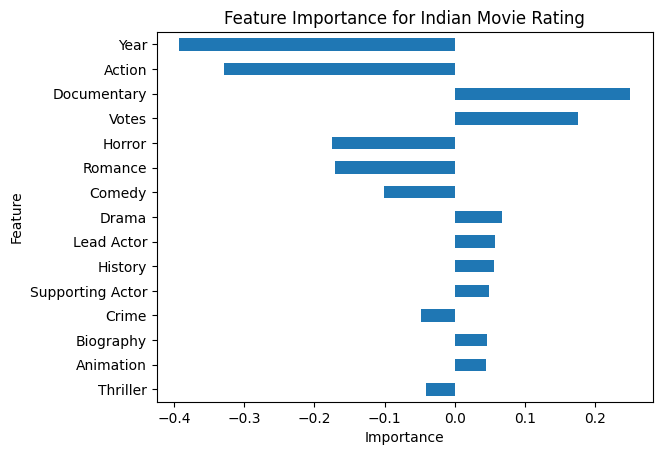

In [159]:
feat_imp.sort_values(key=abs).tail(15).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Indian Movie Rating');

# Save Model

In [174]:
import pickle

# save model (Linear Regression)
with open('model/Indian_Movie_Rating_Prediction.pkl', 'wb') as f:
  pickle.dump(lr, f)

In [175]:
# load model
with open('model/Indian_Movie_Rating_Prediction.pkl', 'rb') as f:
  model_lr = pickle.load(f)

# Creating .py File

In [216]:
def wrangle(filepath):
  # Read csv file
  df = pd.read_csv(filepath, encoding='latin1')

  if type(df['Year']) == 'object':
    # Replace parenthesis and convert `Year` from obejct to float
    df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype('float64')
  else:
    # Convert `Year`` to numeric 
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    # `Year` is not object and has '-' in it
    mask = (df['Year'].notnull()) & (df['Year'] < 0)

    # remove '-'
    df.loc[mask, 'Year'] = df.loc[mask, 'Year'].abs()


  # Remove non-numeric characters (comma, letters etc.)
  df['Votes'] = df['Votes'].replace('[^\d.]', '', regex=True).astype('float64')

  # Split genres and create binary indicator columns
  genres = df['Genre'].str.get_dummies(', ')

  # Concat old and new dataframe
  df = pd.concat([df, genres], axis=1)

  # Fill categorical null values with mode
  categorical_columns = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
  for column in categorical_columns:
    most_frequent_value = df[column].mode()[0]
    df[column].fillna(most_frequent_value, inplace=True)

  # Remove outliers in `Votes`
  low, high = df['Votes'].quantile([0.1, 0.9])
  mask_votes = df['Votes'].between(low, high)

  df = df[mask_votes]

  # Initialize `LabelEncoder` and convert categorical value to numerical value
  encoder = LabelEncoder()
  df['Directors'] = encoder.fit_transform(df['Director'])
  df['Lead Actor'] = encoder.fit_transform(df['Actor 1'])
  df['Supporting Actor'] = encoder.fit_transform(df['Actor 2'])
  df['Side Actor'] = encoder.fit_transform(df['Actor 3'])

   # Columns to be dropped due to above 50% null values, binary indicator columns, high cardinality and categorical value
  drop_columns = ['Duration', 'Genre', 'Name', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

  # Drop columns
  df.drop(columns=drop_columns, inplace=True)

  # Drop old index and reset new index
  df.reset_index(drop=True, inplace=True)

  return df


def make_prediction(data_filepath, model_filepath):
  X_test = wrangle(data_filepath)

  # Scaling the testing data
  scale = StandardScaler()
  X_test = scale.fit_transform(X_test)

  # load model
  with open(model_filepath, 'rb') as f:
    model = pickle.load(f)

  y_test_pred = model.predict(X_test)
  y_test_pred = pd.Series(y_test_pred)
  return y_test_pred

In [ ]:
pred = make_prediction(
    'dataset/movie_test_data.csv',
    'model/Indian_Movie_Rating_Prediction.pkl'
)
print(pred)